In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier

from src.crf import (
    MLPClassifier,
    MLPCRFClassifier,
    mlp_loss,
    mlpcrf_loss,
    plot_predict_crf,
    train_crf,
)
from src.data import batch_dataset, load_data, split_data, time_series_split, drop_data
from src.forest import plot_predict_forest, train_forest

In [2]:
df = load_data()
dataset = split_data(df, scale="normalize")
seq_dataset = batch_dataset(dataset, sequence_length=25)

(x_train, y_train), (x_test, y_test) = dataset
(seq_x_train, seq_y_train), (seq_x_test, seq_y_test) = seq_dataset


In [ ]:
report = ProfileReport(df)
report.to_notebook_iframe()

array([<AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>], dtype=object)

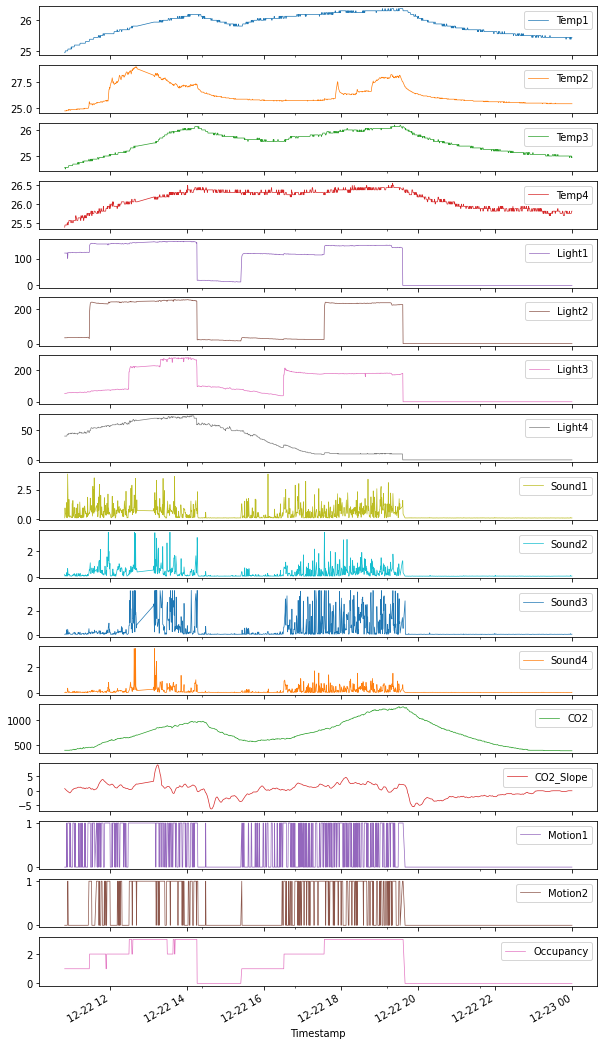

In [4]:
df[df["Timestamp"].dt.date == df["Timestamp"].dt.date.min()].plot(
    x="Timestamp", subplots=True, figsize=(10, 20), lw=0.7
)

# Time Series Split dla całego zbioru

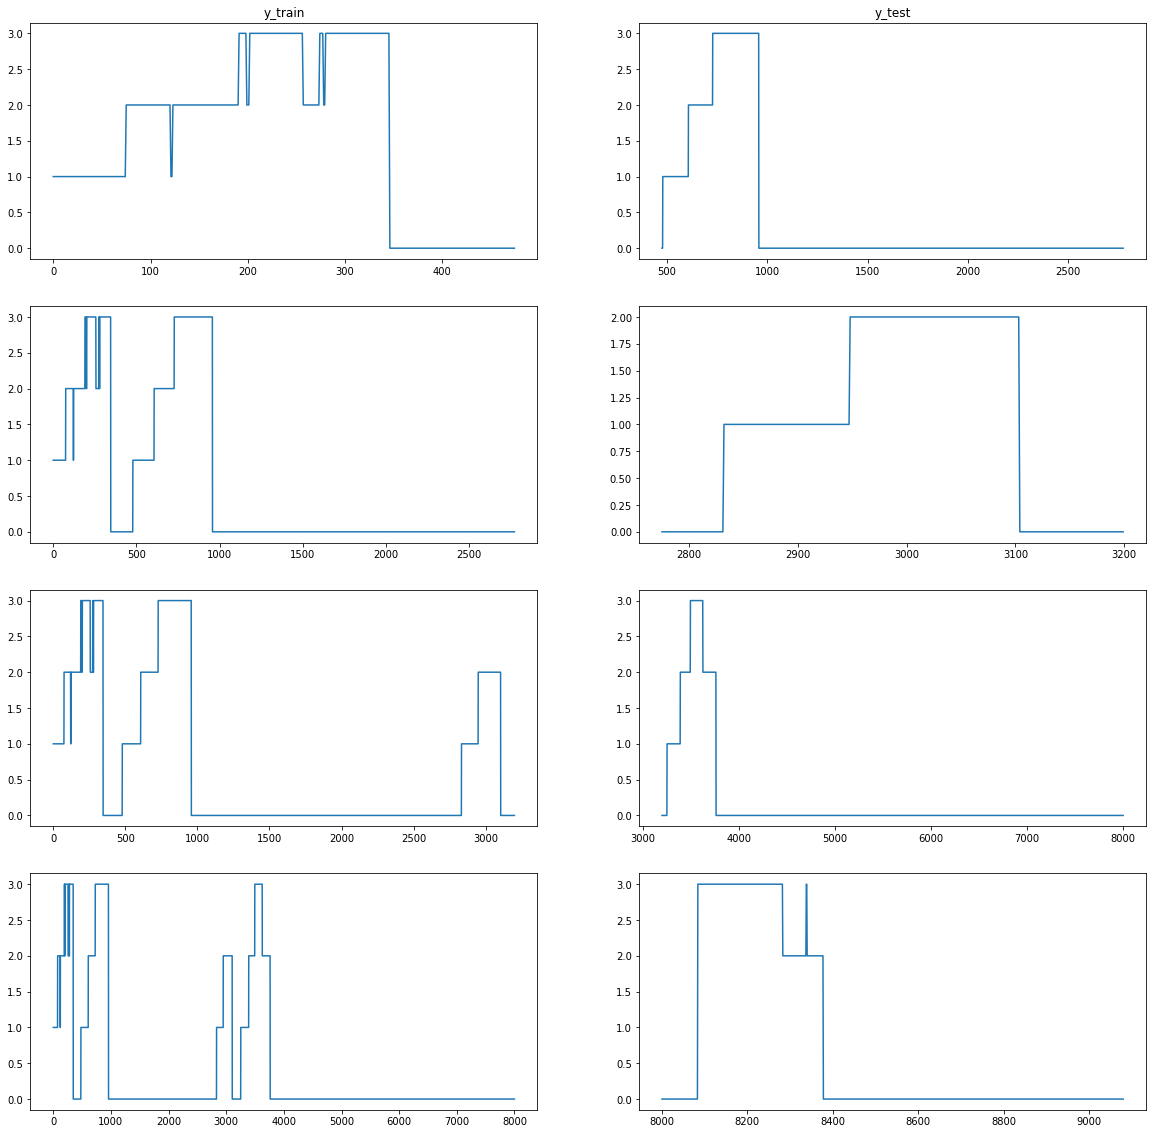

In [8]:
series = time_series_split(df)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

axes[0][0].set_title("y_train")
axes[0][1].set_title("y_test")

for s, (ax1, ax2) in zip(series, axes):
    (x_train, y_train), (x_test, y_test) = s
    y_train.plot(ax=ax1)
    y_test.plot(ax=ax2)

# Dane bez nocy i pustych okresów

0    1251
2     748
3     694
1     459
Name: Occupancy, dtype: int64


<AxesSubplot:>

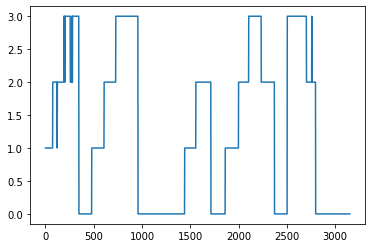

In [75]:
dropped = drop_data(df)
print(dropped["Occupancy"].value_counts())
dropped["Occupancy"].plot()

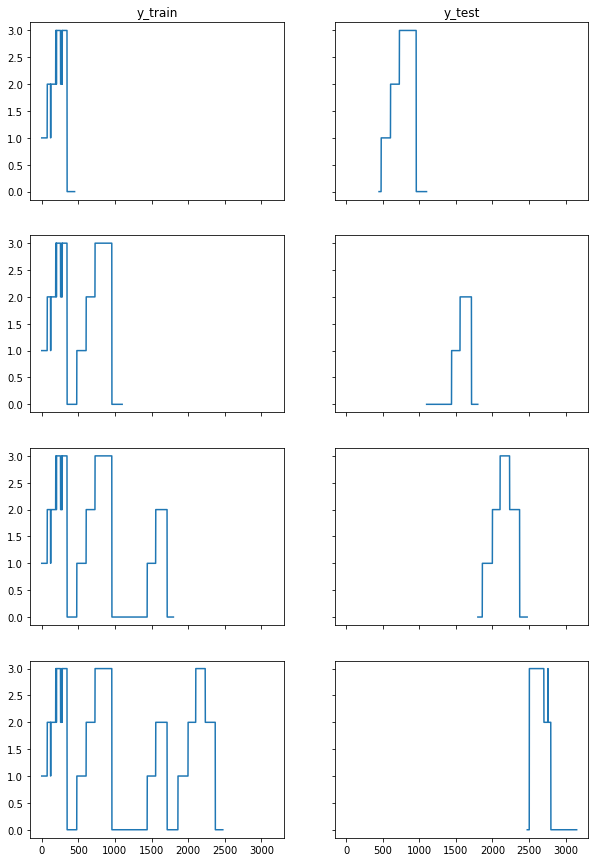

In [82]:
dropped_series = time_series_split(dropped, split_points=[450, 1100, 1800, 2475])
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15), sharex=True, sharey=True)

axes[0][0].set_title("y_train")
axes[0][1].set_title("y_test")

for s, (ax1, ax2) in zip(dropped_series, axes):
    (x_train, y_train), (x_test, y_test) = s
    y_train.plot(ax=ax1)
    y_test.plot(ax=ax2)

# RandomForest

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       703
           1       0.00      0.00      0.00         0
           2       0.20      0.44      0.27        93
           3       0.32      0.12      0.17       201

    accuracy                           0.76       997
   macro avg       0.38      0.39      0.36       997
weighted avg       0.79      0.76      0.76       997



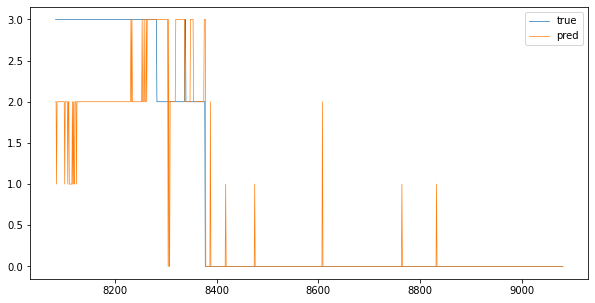

In [5]:
forest = train_forest(RandomForestClassifier(), dataset)
plot_predict_forest(forest, x_test, y_test)

# Simple MLP

  0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       681
           1       0.00      0.00      0.00         0
           2       0.12      0.17      0.14        93
           3       0.40      0.23      0.29       201

    accuracy                           0.76       975
   macro avg       0.36      0.35      0.35       975
weighted avg       0.75      0.76      0.75       975



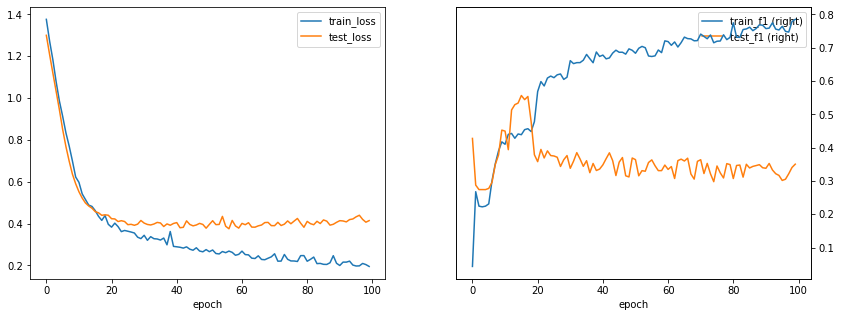

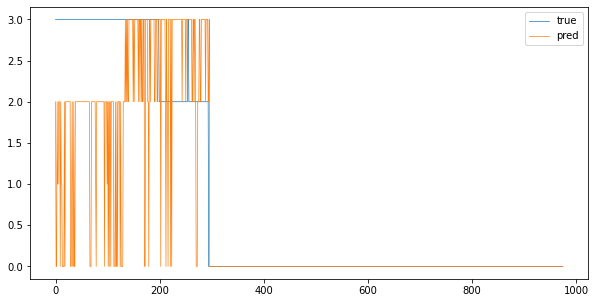

In [6]:
mlp_model = MLPClassifier([64], 4, 12)
_, mlp_log = train_crf(
    model=mlp_model,
    loss_fn=mlp_loss,
    dataset=seq_dataset,
    n_epochs=100,
    lr=0.0005,
    batch_size=16,
    use_mask=False,
)
plot_predict_crf(mlp_model, seq_x_test, seq_y_test)

# MLP CRF

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       681
           2       0.34      0.72      0.46        93
           3       0.74      0.37      0.49       201

    accuracy                           0.84       975
   macro avg       0.69      0.70      0.65       975
weighted avg       0.88      0.84      0.84       975



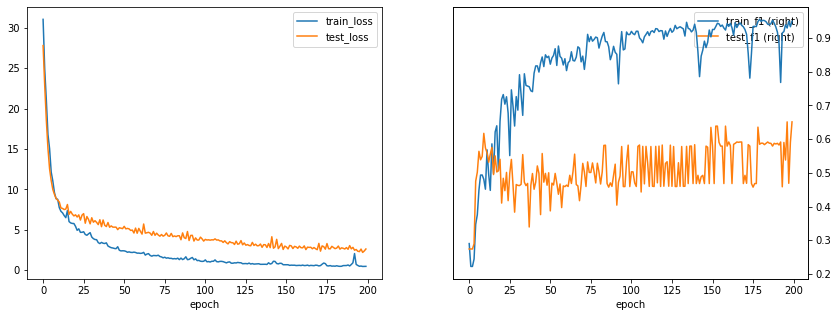

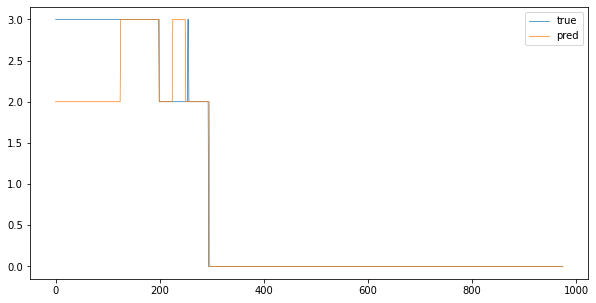

In [7]:
mlpcrf_model = MLPCRFClassifier([64], 4, 12)
_, mlpcrf_log = train_crf(
    model=mlpcrf_model,
    loss_fn=mlpcrf_loss,
    dataset=seq_dataset,
    n_epochs=200,
    lr=0.001,
    batch_size=16,
    use_mask=False,
)
plot_predict_crf(mlpcrf_model, seq_x_test, seq_y_test)